### * Key Takeaways from EDA:

* There are 1482535 rows and 7 features in the dataset.
    * Name
    * Item Condition Id
    * Category Name
    * Brand Name
    * Shipping
    * Item Description
    * Price (Target Feature)
    
* Target feature Price is Right Skewed data.

* Mean value of Price is 16$.

* 97% of products are in good condition, only small percentage is defective ones.

* Shipping Cost mostly paid by the buyer.

* Brand is the key factor in determining the cost of an item.

* Almost 10 branded items composed 90% of product listing.

* Large part of items listed are women’s products like clothing, cosmetics, etc.,

* Mean price of Items under condition-5 (Poor condition) is higher than Items under condition-1 (New condition) is because of Items under condition-5 are mostly Branded items and also electronic items.

* Brands like
    * Nike
    * Victoria’s Secret
    * Apple
    * PINK
    * Louis Vuitton
are has higher value than others item brands.

* Products are classified into three groups based on price,
    * Cheap
    * Affordable
    * Expensive

* Cheap:
    * Most percentage of items under this group in unbranded (i.e.) brand name is not present.
    * It contains mostly clothing, beauty products.

* Affordable:
    * Here some branded items also present.
    * It contains branded cloths, athletic wear, games, toys, branded beauty products.

* Expensive:
    * In this group mostly branded items are present.
    * It contains Electronic items like Mobile phone, iPad, Game Console, Wood items, branded handbags.

* When comparing cheap and affordable items, mostly same item types are present in both group but branded items are more in affordable group and hence increase in the price of a item.

### Feature Engineering Techniques Used:
* Ordinal encoding technique is used for Item Condition feature.

* OneHotEncoding is used for features,
    * Brand Name.
    * Category (Sub Level 1, Sub Level 2, Sub Level 3).

* Fasttext encoding and TFIDF are used for features,
    * Product Name.
    * Item Description.

* New feature called Is_Bundle is created using bundled information. For bundled item Is_Bundle = 1 otherwise Is_Bundle = 0.

* New feature called item_description_score is created, which have sentiment score of item description.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from scipy.sparse import coo_matrix, hstack
from gensim.models.fasttext import FastText
from gensim.models import KeyedVectors
from gensim import corpora
import collections
import json
from wordcloud import WordCloud, STOPWORDS
import re
import nltk
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from num2words import num2words
from tqdm import tqdm
import string
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
from prettytable import PrettyTable

from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV
import joblib
from IPython.display import Image

ModuleNotFoundError: No module named 'lightgbm'

In [2]:
df = pd.read_csv('Dataset/train_preprocessed_2.tsv', sep='\t', index_col='train_id')
df.head()

C:\Users\Srikandan\anaconda3\envs\tensorflow_gpu\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,name,item_condition_id,brand_name,price,shipping,item_description,sub_l1,sub_l2,sub_l3,contains_bundle,item_description_score
train_id,,,,,,,,,,,
0,mlb cincinnati reds t shirt size xl,3,mlb,10.0,1,miss,men,tops,t-shirts,0,0
1,razer blackwidow chroma keyboard,3,Razer,52.0,0,keyboard great condition work like come box po...,electronics,computers & tablets,components & parts,0,3
2,ava viv blouse,1,Target,10.0,1,adorable top hint lace key hole back pale pink...,women,tops & blouses,blouse,0,3
3,leather horse statue,1,miss,35.0,1,new tag leather horse retail rm stand foot hig...,home,home décor,home décor accents,0,3
4,24k gold plate rise,1,miss,44.0,0,complete certificate authenticity,women,jewelry,necklaces,0,2


In [3]:
X = df.drop(columns=['price'])
print(X.shape, '\n')

y = df['price']
print(y.shape)

(1476189, 10) 

(1476189,)


In [4]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.30, random_state=42)

In [5]:
print(X_train.shape, '\n')
print(X_cv.shape)

(1033332, 10) 

(442857, 10)


In [6]:
print(y_train.shape, '\n')
print(y_cv.shape)

(1033332,) 

(442857,)


# * OneHotEncoding + TFIDF:

#### * OneHotEncoded Features (Brand Name, Category_Sub_1, Category_Sub_2, Category_Sub_3).

In [104]:
brand_encoder = OneHotEncoder(handle_unknown='ignore')

onehot_brand_xtrain = brand_encoder.fit_transform(X_train['brand_name'].values.reshape(-1, 1))
onehot_brand_xcv = brand_encoder.transform(X_cv['brand_name'].values.reshape(-1, 1))

In [105]:
sub1_encoder = OneHotEncoder(handle_unknown='ignore')

onehot_sub_l1_xtrain = sub1_encoder.fit_transform(X_train['sub_l1'].values.reshape(-1, 1))
onehot_sub_l1_xcv = sub1_encoder.transform(X_cv['sub_l1'].values.reshape(-1, 1))

In [106]:
sub2_encoder = OneHotEncoder(handle_unknown='ignore')

onehot_sub_l2_xtrain = sub2_encoder.fit_transform(X_train['sub_l2'].values.reshape(-1, 1))
onehot_sub_l2_xcv = sub2_encoder.transform(X_cv['sub_l2'].values.reshape(-1, 1))

In [107]:
sub3_encoder = OneHotEncoder(handle_unknown='ignore')

onehot_sub_l3_xtrain = sub3_encoder.fit_transform(X_train['sub_l3'].values.reshape(-1, 1))
onehot_sub_l3_xcv = sub3_encoder.transform(X_cv['sub_l3'].values.reshape(-1, 1))

In [108]:
print(onehot_brand_xtrain[0].shape, onehot_sub_l1_xtrain[0].shape, onehot_sub_l2_xtrain[0].shape, onehot_sub_l3_xtrain[0].shape)

(1, 4659) (1, 10) (1, 113) (1, 857)


#### * TFIDF Vectorizer (Item Name, Item Description).

In [109]:
tfidf_name = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_features=10000)

tfidf_xtrain_name = tfidf_name.fit_transform(X_train['name'].values)
tfidf_xcv_name = tfidf_name.transform(X_cv['name'].values)

In [110]:
tfidf_description = TfidfVectorizer(ngram_range=(1, 2), min_df=10, max_features=10000)

tfidf_xtrain_description = tfidf_description.fit_transform(X_train['item_description'].values)
tfidf_xcv_description = tfidf_description.transform(X_cv['item_description'].values)

In [111]:
item_condition_xtrain = coo_matrix(X_train['item_condition_id'].values).reshape(len(X_train) ,1)
shipping_xtrain = coo_matrix(X_train['shipping'].values).reshape(len(X_train) ,1)
contains_bundle_xtrain = coo_matrix(X_train['contains_bundle'].values).reshape(len(X_train) ,1)
item_description_score_xtrain = coo_matrix(X_train['item_description_score'].values).reshape(len(X_train) ,1)

item_condition_xcv = coo_matrix(X_cv['item_condition_id'].values).reshape(len(X_cv) ,1)
shipping_xcv = coo_matrix(X_cv['shipping'].values).reshape(len(X_cv) ,1)
contains_bundle_xcv = coo_matrix(X_cv['contains_bundle'].values).reshape(len(X_cv) ,1)
item_description_score_xcv = coo_matrix(X_cv['item_description_score'].values).reshape(len(X_cv) ,1)

In [112]:
train_tf_onehot_data = hstack([onehot_brand_xtrain, onehot_sub_l1_xtrain, onehot_sub_l2_xtrain, onehot_sub_l3_xtrain, tfidf_xtrain_name, tfidf_xtrain_description, 
                        item_condition_xtrain, shipping_xtrain, contains_bundle_xtrain, item_description_score_xtrain])

cv_tf_onehot_data = hstack([onehot_brand_xcv, onehot_sub_l1_xcv, onehot_sub_l2_xcv, onehot_sub_l3_xcv, tfidf_xcv_name, tfidf_xcv_description, 
                        item_condition_xcv, shipping_xcv, contains_bundle_xcv, item_description_score_xcv])

In [113]:
# scipy.sparse.save_npz('Featured Engineered dataset/train_tf_onehot_data.npz', train_tf_onehot_data)
# scipy.sparse.save_npz('Featured Engineered dataset/cv_tf_onehot_data.npz', cv_tf_onehot_data)

# * OneHotEncoding + Fasttext:

#### * Fasttext Word Embedding (Item Name, Item Description).

In [62]:
fast_item_name_train_model = FastText(sentences=[i for i in X_train['name'].str.split(' ')], size=150, window=3, min_count=2, max_vocab_size=10000)

In [63]:
name_length = 25

fast_item_name_train_data = []
for row in tqdm(X_train['name']):
    vectors = [np.mean(fast_item_name_train_model.wv[word]) for word in row.split(' ')]
    if len(vectors) < name_length:
        vectors.extend([0 for i in range(name_length-len(vectors))])
    elif len(vectors) > name_length:
        vectors = vectors[0:name_length]
    fast_item_name_train_data.append(vectors)
    
fast_item_name_train_data = np.asarray(fast_item_name_train_data)

100%|█████████████████████████████████████████████████████████████████████| 1033332/1033332 [01:00<00:00, 17127.29it/s]


In [64]:
fast_item_name_cv_data = []
for row in tqdm(X_cv['name']):
    vectors = [np.mean(fast_item_name_train_model.wv[word]) for word in row.split(' ')]
    if len(vectors) < name_length:
        vectors.extend([0 for i in range(name_length-len(vectors))])
    elif len(vectors) > name_length:
        vectors = vectors[0:name_length]
    fast_item_name_cv_data.append(vectors)
    
fast_item_name_cv_data = np.asarray(fast_item_name_cv_data)

100%|███████████████████████████████████████████████████████████████████████| 442857/442857 [00:25<00:00, 17253.47it/s]


In [65]:
fast_item_name_train_data = scipy.sparse.csr_matrix(fast_item_name_train_data)
fast_item_name_cv_data = scipy.sparse.csr_matrix(fast_item_name_cv_data)

In [66]:
fast_item_desc_train_model = FastText(sentences=[i for i in X_train['item_description'].str.split(' ')], size=200, window=3, min_count=5, max_vocab_size=10000)

In [67]:
description_length = 150

fast_item_description_xtrain_data = []
for row in tqdm(X_train['name']):
    vectors = [np.mean(fast_item_name_train_model.wv[word]) for word in row.split(' ')]
    if len(vectors) < description_length:
        vectors.extend([0 for i in range(description_length-len(vectors))])
    elif len(vectors) > description_length:
        vectors = vectors[0:description_length]
    fast_item_description_xtrain_data.append(vectors)
fast_item_description_xtrain_data = np.asarray(fast_item_description_xtrain_data)

100%|█████████████████████████████████████████████████████████████████████| 1033332/1033332 [01:03<00:00, 16313.87it/s]


In [68]:
fast_item_description_xcv_data = []
for row in tqdm(X_cv['name']):
    vectors = [np.mean(fast_item_name_train_model.wv[word]) for word in row.split(' ')]
    if len(vectors) < description_length:
        vectors.extend([0 for i in range(description_length-len(vectors))])
    elif len(vectors) > description_length:
        vectors = vectors[0:description_length]
    fast_item_description_xcv_data.append(vectors)
fast_item_description_xcv_data = np.asarray(fast_item_description_xcv_data)

100%|███████████████████████████████████████████████████████████████████████| 442857/442857 [00:26<00:00, 16705.03it/s]


In [69]:
fast_item_description_xtrain_data = scipy.sparse.csr_matrix(fast_item_description_xtrain_data)
fast_item_description_xcv_data = scipy.sparse.csr_matrix(fast_item_description_xcv_data)

In [70]:
train_fasttext_onehot_data = hstack([onehot_brand_xtrain, onehot_sub_l1_xtrain, onehot_sub_l2_xtrain, onehot_sub_l3_xtrain, fast_item_name_train_data, fast_item_description_xtrain_data, 
                        item_condition_xtrain, shipping_xtrain, contains_bundle_xtrain, item_description_score_xtrain])

cv_fasttext_onehot_data = hstack([onehot_brand_xcv, onehot_sub_l1_xcv, onehot_sub_l2_xcv, onehot_sub_l3_xcv, fast_item_name_cv_data, fast_item_description_xcv_data, 
                        item_condition_xcv, shipping_xcv, contains_bundle_xcv, item_description_score_xcv]) 

In [71]:
# scipy.sparse.save_npz('Featured Engineered dataset/train_fasttext_onehot_data.npz', train_fasttext_onehot_data)
# scipy.sparse.save_npz('Featured Engineered dataset/cv_fasttext_onehot_data.npz', cv_fasttext_onehot_data)

### * Data Loading:

In [7]:
train_tf_onehot_data = scipy.sparse.load_npz('Featured Engineered dataset/train_tf_onhot_data.npz')
cv_tf_onhot_data = scipy.sparse.load_npz('Featured Engineered dataset/cv_tf_onhot_data.npz')

train_fast_onehot_data = scipy.sparse.load_npz('Featured Engineered dataset/train_fasttext_onehot_data.npz')
cv_fast_onhot_data = scipy.sparse.load_npz('Featured Engineered dataset/cv_fasttext_onehot_data.npz')

### * Linear Regressiojn Model:

#### 1. Linear Regression Model with OneHotEcoder + TFIDF:

In [17]:
params = {
    'alpha': [0.1,0.01,0.001],
    'learning_rate': ['constant','optimal','invscaling','adaptive'],
    'max_iter': [100, 1000, 1500, 2000]
}

In [11]:
model = SGDRegressor()
linear_regression = GridSearchCV(estimator=model, param_grid=params, cv=10, n_jobs=8, verbose=2)
linear_regression.fit(X=train_tf_onehot_data, y=y_train.values)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   26.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 57.4min
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed: 116.3min
[Parallel(n_jobs=8)]: Done 480 out of 480 | elapsed: 175.3min finished


GridSearchCV(cv=10, estimator=SGDRegressor(), n_jobs=8,
             param_grid={'alpha': [0.1, 0.01, 0.001],
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'max_iter': [100, 1000, 1500, 2000]},
             verbose=2)

In [12]:
linear_regression.best_params_

{'alpha': 0.001, 'learning_rate': 'adaptive', 'max_iter': 100}

In [13]:
predicted = linear_regression.predict(cv_tf_onhot_data)

In [15]:
temp = []
for i in predicted.tolist():
    if i<0:
        temp.append(0.0)
    else:
        temp.append(i) 
        
predicted = temp

In [16]:
print('Linear Regression Accuracy :', np.sqrt(mean_squared_log_error(y_cv, predicted)))

Linear Regression Accuracy : 0.6288816370284527


#### 2. Linear Regression Model with OneHotEcoder + Fasttext:

In [21]:
model = SGDRegressor()
linear_regression = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=8, verbose=2)
linear_regression.fit(X=train_fast_onehot_data, y=y_train.values)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   56.5s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 36.9min
[Parallel(n_jobs=8)]: Done 240 out of 240 | elapsed: 59.8min finished


GridSearchCV(cv=5, estimator=SGDRegressor(), n_jobs=8,
             param_grid={'alpha': [0.1, 0.01, 0.001],
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'max_iter': [100, 1000, 1500, 2000]},
             verbose=2)

In [22]:
linear_regression.best_params_

{'alpha': 0.001, 'learning_rate': 'adaptive', 'max_iter': 1000}

In [23]:
predicted = linear_regression.predict(cv_fast_onhot_data)

In [24]:
temp = []
for i in predicted.tolist():
    if i<0:
        temp.append(0.0)
    else:
        temp.append(i) 
        
predicted = temp

In [25]:
print('Linear Regression Accuracy (OneHotEcoder + Fasttext) :', np.sqrt(mean_squared_log_error(y_cv, predicted)))

Linear Regression Accuracy (OneHotEcoder + Fasttext) : 0.6638830712659046


#### 3. Ridge Regression Model with OneHotEcoder + TFIDF:

In [38]:
params = {
    'alpha': [0.1,0.01,0.001],
    'learning_rate': ['constant','optimal','invscaling','adaptive'],
    'max_iter': [100, 1000, 1500, 2000],
    'penalty': ['l2']
}

In [40]:
model = SGDRegressor()
ridge_regression = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=8, verbose=2)
ridge_regression.fit(X=train_tf_onehot_data, y=y_train.values)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 48.3min
[Parallel(n_jobs=8)]: Done 240 out of 240 | elapsed: 78.1min finished


GridSearchCV(cv=5, estimator=SGDRegressor(), n_jobs=8,
             param_grid={'alpha': [0.1, 0.01, 0.001],
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'max_iter': [100, 1000, 1500, 2000],
                         'penalty': ['l2']},
             verbose=2)

In [41]:
ridge_regression.best_params_

{'alpha': 0.001,
 'learning_rate': 'adaptive',
 'max_iter': 2000,
 'penalty': 'l2'}

In [45]:
predicted = ridge_regression.predict(cv_tf_onhot_data)

In [46]:
temp = []
for i in predicted.tolist():
    if i<0:
        temp.append(0.0)
    else:
        temp.append(i) 
        
predicted = temp

In [47]:
print('Ridge Regression Accuracy (OneHotEcoder + TFIDF) :', np.sqrt(mean_squared_log_error(y_cv, predicted)))

Ridge Regression Accuracy (OneHotEcoder + TFIDF) : 0.6288773326651926


#### 4. Ridge Regression Model with OneHotEcoder + Fasttext:

In [48]:
params = {
    'alpha': [0.1,0.01,0.001],
    'learning_rate': ['constant','optimal','invscaling','adaptive'],
    'max_iter': [100, 1000, 1500, 2000],
    'penalty': ['l2']
}

In [49]:
params

{'alpha': [0.1, 0.01, 0.001],
 'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
 'max_iter': [100, 1000, 1500, 2000],
 'penalty': ['l2']}

In [50]:
model = SGDRegressor()
ridge_regression = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=8, verbose=2)
ridge_regression.fit(X=train_fast_onehot_data, y=y_train.values)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   52.6s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 36.9min
[Parallel(n_jobs=8)]: Done 240 out of 240 | elapsed: 59.5min finished


GridSearchCV(cv=5, estimator=SGDRegressor(), n_jobs=8,
             param_grid={'alpha': [0.1, 0.01, 0.001],
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'max_iter': [100, 1000, 1500, 2000],
                         'penalty': ['l2']},
             verbose=2)

In [51]:
predicted = ridge_regression.predict(cv_fast_onhot_data)

In [52]:
temp = []
for i in predicted.tolist():
    if i<0:
        temp.append(0.0)
    else:
        temp.append(i) 
        
predicted = temp

In [53]:
print('Ridge Regression Accuracy (OneHotEcoder + Fasttext) :', np.sqrt(mean_squared_log_error(y_cv, predicted)))

Ridge Regression Accuracy (OneHotEcoder + Fasttext) : 0.6636822822507776


#### 5. Lasso Regression Model with OneHotEcoder + TFIDF:

In [57]:
params = {
    'alpha': [0.1,0.01,0.001],
    'learning_rate': ['constant','optimal','invscaling','adaptive'],
    'max_iter': [100, 1000, 1500, 2000],
    'penalty': ['l1']
}

In [59]:
model = SGDRegressor()
lasso_regression = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=8, verbose=2)
lasso_regression.fit(X=train_tf_onehot_data, y=y_train.values)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 61.9min
[Parallel(n_jobs=8)]: Done 240 out of 240 | elapsed: 107.6min finished


GridSearchCV(cv=5, estimator=SGDRegressor(), n_jobs=8,
             param_grid={'alpha': [0.1, 0.01, 0.001],
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'max_iter': [100, 1000, 1500, 2000],
                         'penalty': ['l1']},
             verbose=2)

In [62]:
lasso_regression.best_params_

{'alpha': 0.001,
 'learning_rate': 'adaptive',
 'max_iter': 2000,
 'penalty': 'l1'}

In [63]:
predicted = lasso_regression.predict(cv_tf_onhot_data)

In [64]:
temp = []
for i in predicted.tolist():
    if i<0:
        temp.append(0.0)
    else:
        temp.append(i) 
        
predicted = temp

In [65]:
print('Lasso Regression Accuracy (OneHotEcoder + TFIDF) :', np.sqrt(mean_squared_log_error(y_cv, predicted)))

Lasso Regression Accuracy (OneHotEcoder + TFIDF) : 0.6541920512368966


#### 6. Lasso Regression Model with OneHotEcoder + Fasttext:

In [68]:
model = SGDRegressor()
lasso_regression = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=8, verbose=2)
lasso_regression.fit(X=train_fast_onehot_data, y=y_train.values)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   48.3s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 38.5min
[Parallel(n_jobs=8)]: Done 240 out of 240 | elapsed: 66.7min finished


GridSearchCV(cv=5, estimator=SGDRegressor(), n_jobs=8,
             param_grid={'alpha': [0.1, 0.01, 0.001],
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'max_iter': [100, 1000, 1500, 2000],
                         'penalty': ['l1']},
             verbose=2)

In [76]:
lasso_regression.best_params_

{'alpha': 0.001,
 'learning_rate': 'adaptive',
 'max_iter': 1000,
 'penalty': 'l1'}

In [73]:
predicted = lasso_regression.predict(cv_fast_onhot_data)

In [74]:
temp = []
for i in predicted.tolist():
    if i<0:
        temp.append(0.0)
    else:
        temp.append(i) 
        
predicted = temp

In [75]:
print('Lasso Regression Accuracy (OneHotEcoder + Fasttext) :', np.sqrt(mean_squared_log_error(y_cv, predicted)))

Lasso Regression Accuracy (OneHotEcoder + Fasttext) : 0.6598378544741845


#### 7. Elasticnet Regression Model with OneHotEcoder + TFIDF:

In [8]:
params = {
    'alpha': [0.1,0.01,0.001],
    'learning_rate': ['constant','optimal','invscaling','adaptive'],
    'max_iter': [100, 1000, 1500, 2000],
    'penalty': ['elasticnet']
}

In [10]:
model = SGDRegressor()
elastic_regression = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=8, verbose=2)
elastic_regression.fit(X=train_tf_onehot_data, y=y_train.values)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 59.6min
[Parallel(n_jobs=8)]: Done 240 out of 240 | elapsed: 173.2min finished


GridSearchCV(cv=5, estimator=SGDRegressor(), n_jobs=8,
             param_grid={'alpha': [0.1, 0.01, 0.001],
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'max_iter': [100, 1000, 1500, 2000],
                         'penalty': ['elasticnet']},
             verbose=2)

In [15]:
elastic_regression.best_params_

{'alpha': 0.001,
 'learning_rate': 'adaptive',
 'max_iter': 2000,
 'penalty': 'elasticnet'}

In [16]:
predicted = elastic_regression.predict(cv_tf_onhot_data)

In [17]:
temp = []
for i in predicted.tolist():
    if i<0:
        temp.append(0.0)
    else:
        temp.append(i) 
        
predicted = temp

In [18]:
print('Elasticnet Regression Accuracy (OneHotEcoder + TFIDF) :', np.sqrt(mean_squared_log_error(y_cv, predicted)))

Elasticnet Regression Accuracy (OneHotEcoder + TFIDF) : 0.6304825100976332


#### 8. Elasticnet Regression Model with OneHotEcoder + Fasttext:

In [10]:
params = {
    'alpha': [0.1,0.01,0.001],
    'learning_rate': ['constant','optimal','invscaling','adaptive'],
    'max_iter': [100, 1000, 1500, 2000],
    'penalty': ['elasticnet']
}

In [12]:
model = SGDRegressor()
elastic_regression = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=-1, verbose=2)
elastic_regression.fit(X=train_fast_onehot_data, y=y_train.values)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 43.0min finished


GridSearchCV(cv=5, estimator=SGDRegressor(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.01, 0.001],
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'max_iter': [100, 1000, 1500, 2000],
                         'penalty': ['elasticnet']},
             verbose=2)

In [13]:
predicted = elastic_regression.predict(cv_fast_onhot_data)

In [14]:
temp = []
for i in predicted.tolist():
    if i<0:
        temp.append(0.0)
    else:
        temp.append(i) 
        
predicted = temp

In [15]:
print('ElasticNet Regression Accuracy (OneHotEcoder + Fasttext) :', np.sqrt(mean_squared_log_error(y_cv, predicted)))

ElasticNet Regression Accuracy (OneHotEcoder + Fasttext) : 0.662499648269813


#### 9. Decision Tree Regression Model with OneHotEcoder + TFIDF:

In [8]:
params = {
    'criterion': ['mse', 'friedman_mse'],
    'splitter': ['best'],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 6, 8],
    'max_features': ['sqrt', 'log2']
}

In [10]:
model = DecisionTreeRegressor()
dt_regression = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=8, verbose=2)
dt_regression.fit(X=train_tf_onehot_data, y=y_train.values)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   13.2s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed: 14.9min finished


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=8,
             param_grid={'criterion': ['mse', 'friedman_mse'],
                         'max_depth': [10, 50, 100],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 6, 8], 'splitter': ['best']},
             verbose=2)

In [11]:
dt_regression.best_params_

{'criterion': 'friedman_mse',
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_split': 8,
 'splitter': 'best'}

In [12]:
predicted = dt_regression.predict(cv_tf_onhot_data)

In [13]:
temp = []
for i in predicted.tolist():
    if i<0:
        temp.append(0.0)
    else:
        temp.append(i) 
        
predicted = temp

In [14]:
print('Decision Tree Regression Accuracy (OneHotEcoder + TFIDF) :', np.sqrt(mean_squared_log_error(y_cv, predicted)))

Decision Tree Regression Accuracy (OneHotEcoder + TFIDF) : 0.7232429983948581


#### 10. Decision Tree Regression Model with OneHotEcoder + FastText:

In [17]:
params = {
    'criterion': ['mse', 'friedman_mse'],
    'splitter': ['best'],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 6, 8],
    'max_features': ['sqrt', 'log2']
}

In [18]:
params

{'criterion': ['mse', 'friedman_mse'],
 'splitter': ['best'],
 'max_depth': [10, 50, 100],
 'min_samples_split': [2, 6, 8],
 'max_features': ['sqrt', 'log2']}

In [19]:
model = DecisionTreeRegressor()
dt_regression = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=8, verbose=2)
dt_regression.fit(X=train_fast_onehot_data, y=y_train.values)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 16.8min
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed: 27.2min finished


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=8,
             param_grid={'criterion': ['mse', 'friedman_mse'],
                         'max_depth': [10, 50, 100],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 6, 8], 'splitter': ['best']},
             verbose=2)

In [20]:
dt_regression.best_params_

{'criterion': 'mse',
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_split': 8,
 'splitter': 'best'}

In [21]:
predicted = dt_regression.predict(cv_fast_onhot_data)

In [22]:
temp = []
for i in predicted.tolist():
    if i<0:
        temp.append(0.0)
    else:
        temp.append(i) 
        
predicted = temp

In [23]:
print('Decision Tree Regression Accuracy (OneHotEcoder + TFIDF) :', np.sqrt(mean_squared_log_error(y_cv, predicted)))

Decision Tree Regression Accuracy (OneHotEcoder + TFIDF) : 0.7137738195043923


#### 11. Random Forest Regression Model with OneHotEcoder + TFIDF:

In [18]:
params = {
    'n_estimators': [30],
    'max_depth': [20, 30],
    'min_samples_split': [8],
    'max_features': ['sqrt']
}

In [20]:
model = RandomForestRegressor()
rf_regression = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=-1, verbose=2)
rf_regression.fit(X=train_tf_onehot_data, y=y_train.values)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  2.4min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.5min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [20, 30], 'max_features': ['sqrt'],
                         'min_samples_split': [8], 'n_estimators': [30]},
             verbose=2)

In [21]:
rf_regression.best_params_

{'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_split': 8,
 'n_estimators': 30}

In [22]:
predicted = rf_regression.predict(cv_tf_onhot_data)

In [23]:
temp = []
for i in predicted.tolist():
    if i<0:
        temp.append(0.0)
    else:
        temp.append(i)
        
predicted = temp

In [24]:
print('Random Forest Regression Accuracy (OneHotEcoder + TFIDF) :', np.sqrt(mean_squared_log_error(y_cv, predicted)))

Random Forest Regression Accuracy (OneHotEcoder + TFIDF) : 0.7302909019995318


#### 12. Random Forest Regression Model with OneHotEcoder + FastText:

In [25]:
params = {
    'n_estimators': [30, 50],
    'max_depth': [20, 30, 50],
    'min_samples_split': [8],
    'max_features': ['sqrt']
}

In [26]:
params

{'n_estimators': [30, 50],
 'max_depth': [20, 30, 50],
 'min_samples_split': [8],
 'max_features': ['sqrt']}

In [27]:
model = RandomForestRegressor()
rf_regression = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=-1, verbose=2)
rf_regression.fit(X=train_fast_onehot_data, y=y_train.values)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  8.5min remaining:  8.5min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 30.5min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 50], 'max_features': ['sqrt'],
                         'min_samples_split': [8], 'n_estimators': [30, 50]},
             verbose=2)

In [28]:
rf_regression.best_params_

{'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_split': 8,
 'n_estimators': 50}

In [29]:
predicted = rf_regression.predict(cv_fast_onhot_data)

In [30]:
temp = []
for i in predicted.tolist():
    if i<0:
        temp.append(0.0)
    else:
        temp.append(i) 
        
predicted = temp

In [31]:
print('Random Forest Regression Accuracy (OneHotEcoder + Fasttext) :', np.sqrt(mean_squared_log_error(y_cv, predicted)))

Random Forest Regression Accuracy (OneHotEcoder + TFIDF) : 0.6650374823588304


#### 13. AdaBoost Regression Model with OneHotEcoder + TFIDF:

In [8]:
params = {
    'base_estimator': [DecisionTreeRegressor(max_depth = 1)],
    'n_estimators': [30, 50],
    'learning_rate': [0.1, 0.01],
    'loss': ['linear', 'square']
}

In [10]:
model = AdaBoostRegressor()

ada_regression = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=-1, verbose=2)
ada_regression.fit(X=train_tf_onehot_data, y=y_train.values)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed: 30.6min remaining: 10.2min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 35.7min finished


GridSearchCV(cv=5, estimator=AdaBoostRegressor(), n_jobs=-1,
             param_grid={'base_estimator': [DecisionTreeRegressor(max_depth=1)],
                         'learning_rate': [0.1, 0.01],
                         'loss': ['linear', 'square'],
                         'n_estimators': [30, 50]},
             verbose=2)

In [11]:
ada_regression.best_params_

{'base_estimator': DecisionTreeRegressor(max_depth=1),
 'learning_rate': 0.01,
 'loss': 'square',
 'n_estimators': 30}

In [12]:
predicted = ada_regression.predict(cv_tf_onhot_data)

In [13]:
temp = []
for i in predicted.tolist():
    if i<0:
        temp.append(0.0)
    else:
        temp.append(i) 
        
predicted = temp

In [14]:
print('AdaBoost Regression Accuracy (OneHotEcoder + TFIDF) :', np.sqrt(mean_squared_log_error(y_cv, predicted)))

AdaBoost Regression Accuracy (OneHotEcoder + TFIDF) : 0.8192359613878528


#### 14. AdaBoost Regression Model with OneHotEcoder + FastText:

In [8]:
params = {
    'base_estimator': [DecisionTreeRegressor(max_depth = 1)],
    'n_estimators': [30, 50],
    'learning_rate': [0.1, 0.01],
    'loss': ['square']
}

In [9]:
params

{'base_estimator': [DecisionTreeRegressor(max_depth=1)],
 'n_estimators': [30, 50],
 'learning_rate': [0.1, 0.01],
 'loss': ['square']}

In [10]:
model = AdaBoostRegressor()
ada_regression = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=-1, verbose=2)
ada_regression.fit(X=train_fast_onehot_data, y=y_train.values)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  7.0min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  8.5min finished


GridSearchCV(cv=5, estimator=AdaBoostRegressor(), n_jobs=-1,
             param_grid={'base_estimator': [DecisionTreeRegressor(max_depth=1)],
                         'learning_rate': [0.1, 0.01], 'loss': ['square'],
                         'n_estimators': [30, 50]},
             verbose=2)

In [11]:
ada_regression.best_params_

{'base_estimator': DecisionTreeRegressor(max_depth=1),
 'learning_rate': 0.01,
 'loss': 'square',
 'n_estimators': 30}

In [12]:
predicted = ada_regression.predict(cv_fast_onhot_data)

In [13]:
temp = []
for i in predicted.tolist():
    if i<0:
        temp.append(0.0)
    else:
        temp.append(i) 
        
predicted = temp

In [14]:
print('AdaBoost Regression Accuracy (OneHotEcoder + Fasttext) :', np.sqrt(mean_squared_log_error(y_cv, predicted)))

Random Forest Regression Accuracy (OneHotEcoder + Fasttext) : 0.8193483683404111


#### 15. LightGBM Regression Model with OneHotEcoder + TFIDF:

In [8]:
params = {
    'boosting_type': ['gbdt'],
    'objective': ['regression'],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5],
    'n_estimators': [50, 100],
    'num_leaves': [40]
}

In [10]:
model = LGBMRegressor()

lgbm_regression = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=-1, verbose=2)
lgbm_regression.fit(X=train_tf_onehot_data, y=y_train.values)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed: 26.8min remaining:  8.9min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 30.1min finished


GridSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'],
                         'learning_rate': [0.1, 0.01], 'max_depth': [3, 5],
                         'n_estimators': [50, 100], 'num_leaves': [40],
                         'objective': ['regression']},
             verbose=2)

In [11]:
lgbm_regression.best_params_

{'boosting_type': 'gbdt',
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 100,
 'num_leaves': 40,
 'objective': 'regression'}

In [12]:
predicted = lgbm_regression.predict(cv_tf_onhot_data)

C:\Users\Srikandan\anaconda3\envs\tensorflow_gpu\lib\site-packages\lightgbm\basic.py:597: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


In [13]:
temp = []
for i in predicted.tolist():
    if i<0:
        temp.append(0.0)
    else:
        temp.append(i) 
        
predicted = temp

In [14]:
print('LGBM Regression Accuracy (OneHotEcoder + TFIDF) :', np.sqrt(mean_squared_log_error(y_cv, predicted)))

LGBM Regression Accuracy (OneHotEcoder + TFIDF) : 0.6541871420915752


#### 16. LightGBM Regression Model with OneHotEcoder + FastText:

In [27]:
params = {
    'boosting_type': ['gbdt'],
    'objective': ['regression'],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5],
    'n_estimators': [50, 100],
    'num_leaves': [40]
}

In [28]:
params

{'boosting_type': ['gbdt'],
 'objective': ['regression'],
 'learning_rate': [0.1, 0.01],
 'max_depth': [3, 5],
 'n_estimators': [50, 100],
 'num_leaves': [40]}

In [29]:
model = LGBMRegressor()

lgbm_regression = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=-1, verbose=2)
lgbm_regression.fit(X=train_fast_onehot_data, y=y_train.values)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:   30.6s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   36.7s finished


GridSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'],
                         'learning_rate': [0.1, 0.01], 'max_depth': [3, 5],
                         'n_estimators': [50, 100], 'num_leaves': [40],
                         'objective': ['regression']},
             verbose=2)

In [30]:
lgbm_regression.best_params_

{'boosting_type': 'gbdt',
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 100,
 'num_leaves': 40,
 'objective': 'regression'}

In [31]:
predicted = lgbm_regression.predict(cv_fast_onhot_data)

C:\Users\Srikandan\anaconda3\envs\tensorflow_gpu\lib\site-packages\lightgbm\basic.py:597: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


In [32]:
temp = []
for i in predicted.tolist():
    if i<0:
        temp.append(0.0)
    else:
        temp.append(i) 
        
predicted = temp

In [33]:
print('LGBM Regression Accuracy (OneHotEcoder + Fasttext) :', np.sqrt(mean_squared_log_error(y_cv, predicted)))

LGBM Regression Accuracy (OneHotEcoder + Fasttext) : 0.6763336697112257


### * Different Modelling used and observations:
    
    * There are eight models were used.
    
    * Each modle is tried with hyper parameter tunning.

In [3]:
myTable = PrettyTable(["Model", "Encoder", "RMSLE"])
myTable.add_row(["Linear Regression Model", "OneHotEcoder + TFIDF", "0.62"]) 
myTable.add_row(["Linear Regression Model", "OneHotEcoder + Fasttext", "0.66"])
myTable.add_row(["Ridge Regression Model", "OneHotEcoder + TFIDF", "0.62"]) 
myTable.add_row(["Ridge Regression Model", "OneHotEcoder + Fasttext", "0.66"]) 
myTable.add_row(["Lasso Regression Model", "OneHotEcoder + TFIDF", "0.65"]) 
myTable.add_row(["Lasso Regression Model", "OneHotEcoder + Fasttext", "0.65"]) 
myTable.add_row(["Elasticnet Regression Model", "OneHotEcoder + TFIDF", "0.63"]) 
myTable.add_row(["Elasticnet Regression Model", "OneHotEcoder + Fasttext", "0.66"]) 
myTable.add_row(["Decision Tree Regression Model", "OneHotEcoder + TFIDF", "0.72"]) 
myTable.add_row(["Decision Tree Regression Model", "OneHotEcoder + Fasttext", "0.71"]) 
myTable.add_row(["Random Forest Regression Model", "OneHotEcoder + TFIDF", "0.73"]) 
myTable.add_row(["Random Forest Regression Model", "OneHotEcoder + Fasttext", "0.66"]) 
myTable.add_row(["AdaBoost Regression Model", "OneHotEcoder + TFIDF", "0.81"]) 
myTable.add_row(["AdaBoost Regression Model", "OneHotEcoder + Fasttext", "0.81"]) 
myTable.add_row(["LightGBM Regression Model", "OneHotEcoder + TFIDF", "0.65"]) 
myTable.add_row(["LightGBM Regression Model", "OneHotEcoder + Fasttext", "0.67"])
print(myTable)

+--------------------------------+-------------------------+-------+
|             Model              |         Encoder         | RMSLE |
+--------------------------------+-------------------------+-------+
|    Linear Regression Model     |   OneHotEcoder + TFIDF  |  0.62 |
|    Linear Regression Model     | OneHotEcoder + Fasttext |  0.66 |
|     Ridge Regression Model     |   OneHotEcoder + TFIDF  |  0.62 |
|     Ridge Regression Model     | OneHotEcoder + Fasttext |  0.66 |
|     Lasso Regression Model     |   OneHotEcoder + TFIDF  |  0.65 |
|     Lasso Regression Model     | OneHotEcoder + Fasttext |  0.65 |
|  Elasticnet Regression Model   |   OneHotEcoder + TFIDF  |  0.63 |
|  Elasticnet Regression Model   | OneHotEcoder + Fasttext |  0.66 |
| Decision Tree Regression Model |   OneHotEcoder + TFIDF  |  0.72 |
| Decision Tree Regression Model | OneHotEcoder + Fasttext |  0.71 |
| Random Forest Regression Model |   OneHotEcoder + TFIDF  |  0.73 |
| Random Forest Regression Model |

### * Test Data preprocessing 

In [7]:
train_df = pd.read_csv('Dataset/train_preprocessed_2.tsv', sep='\t', index_col='train_id')
train_df.head()

C:\Users\Srikandan\anaconda3\envs\tensorflow_gpu\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,name,item_condition_id,brand_name,price,shipping,item_description,sub_l1,sub_l2,sub_l3,contains_bundle,item_description_score
train_id,,,,,,,,,,,
0,mlb cincinnati reds t shirt size xl,3,mlb,10.0,1,miss,men,tops,t-shirts,0,0
1,razer blackwidow chroma keyboard,3,Razer,52.0,0,keyboard great condition work like come box po...,electronics,computers & tablets,components & parts,0,3
2,ava viv blouse,1,Target,10.0,1,adorable top hint lace key hole back pale pink...,women,tops & blouses,blouse,0,3
3,leather horse statue,1,miss,35.0,1,new tag leather horse retail rm stand foot hig...,home,home décor,home décor accents,0,3
4,24k gold plate rise,1,miss,44.0,0,complete certificate authenticity,women,jewelry,necklaces,0,2


In [8]:
test_df = pd.read_csv('Dataset/test_stg2.tsv', sep='\t', index_col='test_id')
test_df.head()

C:\Users\Srikandan\anaconda3\envs\tensorflow_gpu\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,name,item_condition_id,category_name,brand_name,shipping,item_description
test_id,,,,,,
0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [9]:
from nltk.corpus import stopwords

# Reference: NLP Assigments
def decontractions(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)
    return phrase

def preprocess(text):
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', ' ', text)
    text = [t for t in text if t not in string.punctuation]
    return ''.join(text)

stop_words = set(stopwords.words("english"))

def removeStopWords(text):
    word_tokens = word_tokenize(text)  
    filtered_sentence = [w for w in word_tokens if not w in list(stop_words)] 
    filtered_sentence = ' '.join(filtered_sentence)
    return filtered_sentence

sp = spacy.load('C:/Users/Srikandan/anaconda3/envs/tensorflow_gpu/Lib/site-packages/en_core_web_sm/en_core_web_sm-2.3.1')

def lemmatizer(text):
    lem_text = sp(text)
    lem_text = [i.lemma_ for i in lem_text]
    return ' '.join(lem_text)

def remove_special_characters(text):
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)

def num_to_word(text):
    digits = [int(s) for s in text.split() if s.isdigit()]
    digits_map = {str(i): num2words(i) for i in digits}
    for i in digits_map.keys():
        text = text.replace(i, digits_map[i])
    return text

def remove_extra_whitespace_tabs(text):
    pattern = r'^\s*|\s\s*'
    return re.sub(pattern, ' ', text).strip()

In [10]:
test_df.loc[test_df['name'].isna(), 'name'] = 'missing'

In [11]:
test_df.loc[test_df['item_description'] == 'No description yet', ['item_description']] = 'missing'

test_df['item_description'].fillna('missing', inplace=True)

np.unique(test_df['item_description'].isna())

array([False])

In [12]:
test_df['name'] = test_df['name'].apply(preprocess)
test_df['name'] = test_df['name'].apply(lemmatizer)
test_df['name'] = test_df['name'].apply(remove_special_characters)
test_df['name'] = test_df['name'].apply(num_to_word)
test_df['name'] = test_df['name'].apply(remove_extra_whitespace_tabs)

In [13]:
test_df['item_description'] = test_df['item_description'].apply(preprocess)
test_df['item_description'] = test_df['item_description'].apply(removeStopWords)
test_df['item_description'] = test_df['item_description'].apply(lemmatizer)
test_df['item_description'] = test_df['item_description'].apply(remove_special_characters)
test_df['item_description'] = test_df['item_description'].apply(num_to_word)
test_df['item_description'] = test_df['item_description'].apply(remove_extra_whitespace_tabs)

In [31]:
test_df.head()

,name,item_condition_id,brand_name,shipping,item_description,sub_l1,sub_l2,sub_l3
test_id,,,,,,,,
0,breast cancer i fight like a girl ring,1,,1,size seven,women,jewelry,rings
1,twenty-five pc new seven five x12 kraft bubble...,1,,1,twenty-five pc new seven five x12 kraft bubble...,other,office supplies,shipping supplies
2,coach bag,1,Coach,1,brand new coach bag buy rm coach outlet,vintage & collectibles,bags and purses,handbag
3,floral kimono,2,,0,floral kimono never wear lightweight perfect h...,women,sweaters,cardigan
4,life after death,3,,1,rediscover life loss love one tony cooke paper...,other,books,religion & spirituality


In [32]:
test_df.to_csv('Dataset/test_stage2_preprocessed_0.tsv', sep="\t")

In [15]:
level_1 = []
level_2 = []
level_3 = []

cate_list = test_df['category_name'].str.split('/')

for i in cate_list:
    if i != i:
        level_1.append('miss')
        level_2.append('miss')
        level_3.append('miss')
    else:
        level_1.append(i[0])
        level_2.append(i[1])
        level_3.append(i[2])
        
sub_l1 = pd.Series(level_1)
sub_l2 = pd.Series(level_2)
sub_l3 = pd.Series(level_3)

test_df.drop(columns=['category_name'], inplace=True)

test_df.head()

,name,item_condition_id,brand_name,shipping,item_description
test_id,,,,,
0,breast cancer i fight like a girl ring,1,NaN,1,size seven
1,twenty-five pc new seven five x12 kraft bubble...,1,NaN,1,twenty-five pc new seven five x12 kraft bubble...
2,coach bag,1,Coach,1,brand new coach bag buy rm coach outlet
3,floral kimono,2,NaN,0,floral kimono never wear lightweight perfect h...
4,life after death,3,NaN,1,rediscover life loss love one tony cooke paper...


In [16]:
test_df['sub_l1'] = sub_l1.str.lower()
test_df['sub_l2'] = sub_l2.str.lower()
test_df['sub_l3'] = sub_l3.str.lower()

test_df.head()

,name,item_condition_id,brand_name,shipping,item_description,sub_l1,sub_l2,sub_l3
test_id,,,,,,,,
0,breast cancer i fight like a girl ring,1,NaN,1,size seven,women,jewelry,rings
1,twenty-five pc new seven five x12 kraft bubble...,1,NaN,1,twenty-five pc new seven five x12 kraft bubble...,other,office supplies,shipping supplies
2,coach bag,1,Coach,1,brand new coach bag buy rm coach outlet,vintage & collectibles,bags and purses,handbag
3,floral kimono,2,NaN,0,floral kimono never wear lightweight perfect h...,women,sweaters,cardigan
4,life after death,3,NaN,1,rediscover life loss love one tony cooke paper...,other,books,religion & spirituality


In [33]:
known_brand_names = list(train_df.loc[train_df['brand_name'] != '', :].sort_values('brand_name')['brand_name'].str.lower())

In [34]:
brand, count = np.unique(known_brand_names, return_counts=True)
known_brand_names = {brand[i] : count[i] for i in range(len(brand))}

In [35]:
known_brand_names_up = []
for i, j in known_brand_names.items():
    if (j > 200):
        known_brand_names_up.append(i)

print(len(known_brand_names_up))
print(known_brand_names_up[:5])

378
['7 for all mankind®', 'abercrombie & fitch', 'acacia swimwear', 'aden & anais', 'adidas']


In [36]:
temp_test_df = test_df.reset_index().copy()
temp_test_df.head(2)

,test_id,name,item_condition_id,brand_name,shipping,item_description,sub_l1,sub_l2,sub_l3
0,0,breast cancer i fight like a girl ring,1,,1,size seven,women,jewelry,rings
1,1,twenty-five pc new seven five x12 kraft bubble...,1,,1,twenty-five pc new seven five x12 kraft bubble...,other,office supplies,shipping supplies


In [37]:
unknown_brand_names_df = temp_test_df.reset_index().loc[temp_test_df['brand_name'] == '', ['test_id', 'name', 'item_description']]
merged_text = unknown_brand_names_df['name'] + ' ' + unknown_brand_names_df['item_description']
unknown_brand_names_df['merged_text'] = merged_text
unknown_brand_names_df.drop(columns=['name', 'item_description'], inplace=True)
unknown_brand_names_df.head(2)

,test_id,merged_text
0,0,breast cancer i fight like a girl ring size seven
1,1,twenty-five pc new seven five x12 kraft bubble...


In [38]:
test_id = list(unknown_brand_names_df['test_id'])
merged_text = list(unknown_brand_names_df['merged_text'])

unknown_brand_names_map = {test_id[i] : merged_text[i] for i in range(len(test_id))}

In [39]:
known_brand_names = []
for i in known_brand_names_up:
    if len(i) > 2:
        known_brand_names.append(i)

print(len(known_brand_names))

374


In [40]:
found_brands = {}
found_names = {}

for brand in tqdm(known_brand_names):
    for i, j in unknown_brand_names_map.items():
        if brand in j:
            found_brands[i] = brand

100%|████████████████████████████████████████████████████████████████████████████████| 374/374 [01:34<00:00,  3.96it/s]


In [90]:
test_df['brand_name'].update(pd.Series(found_brands))

In [92]:
test_df.head()

,name,item_condition_id,brand_name,shipping,item_description,sub_l1,sub_l2,sub_l3
test_id,,,,,,,,
0,breast cancer i fight like a girl ring,1,,1,size seven,women,jewelry,rings
1,twenty-five pc new seven five x12 kraft bubble...,1,,1,twenty-five pc new seven five x12 kraft bubble...,other,office supplies,shipping supplies
2,coach bag,1,Coach,1,brand new coach bag buy rm coach outlet,vintage & collectibles,bags and purses,handbag
3,floral kimono,2,,0,floral kimono never wear lightweight perfect h...,women,sweaters,cardigan
4,life after death,3,,1,rediscover life loss love one tony cooke paper...,other,books,religion & spirituality


In [93]:
test_df.loc[test_df['brand_name'] == '', 'brand_name'] = 'miss'

In [95]:
test_df.loc[test_df['item_description'] == '', 'item_description'] = 'miss'

In [96]:
test_df.loc[test_df['sub_l1'] == '', 'sub_l1'] = 'miss'
test_df.loc[test_df['sub_l2'] == '', 'sub_l1'] = 'miss'
test_df.loc[test_df['sub_l3'] == '', 'sub_l1'] = 'miss'

In [97]:
concate_bundle = list(test_df['name'] + ' ' + test_df['item_description'])

In [98]:
contains_bundle = []
a = 0
for i in concate_bundle:
    if (('bundles' in i) or ('bundle' in i)):
        contains_bundle.append(1)
    else:
        contains_bundle.append(0)

In [99]:
test_df['contains_bundle'] = contains_bundle

In [100]:
senti = SentimentIntensityAnalyzer() 
def get_sentiment_score(data):
    if data != 'miss':
        sentence_sentiment_score = senti.polarity_scores(data)
        compound = sentence_sentiment_score['compound']
        if compound >= 0.5:
            return 3 
        if compound >= (-0.5) and compound < 0.5:
            return 2
        if compound < (-0.5):
            return 1
    else: 
        return 0 

In [101]:
test_df['item_description_score'] = test_df['item_description'].apply(lambda x: get_sentiment_score(x))
test_df.head()

,name,item_condition_id,brand_name,shipping,item_description,sub_l1,sub_l2,sub_l3,contains_bundle,item_description_score
test_id,,,,,,,,,,
0,breast cancer i fight like a girl ring,1,miss,1,size seven,women,jewelry,rings,0,2
1,twenty-five pc new seven five x12 kraft bubble...,1,miss,1,twenty-five pc new seven five x12 kraft bubble...,other,office supplies,shipping supplies,0,3
2,coach bag,1,Coach,1,brand new coach bag buy rm coach outlet,vintage & collectibles,bags and purses,handbag,0,2
3,floral kimono,2,miss,0,floral kimono never wear lightweight perfect h...,women,sweaters,cardigan,0,2
4,life after death,3,miss,1,rediscover life loss love one tony cooke paper...,other,books,religion & spirituality,1,2


In [102]:
# test_df.to_csv('Dataset/test_stage2_preprocessed_1.tsv', sep="\t")

In [13]:
test_df = pd.read_csv('Dataset/test_stage2_preprocessed_1.tsv', sep='\t', index_col='test_id')
test_df.head(2)

C:\Users\Srikandan\anaconda3\envs\tensorflow_gpu\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,name,item_condition_id,brand_name,shipping,item_description,sub_l1,sub_l2,sub_l3,contains_bundle,item_description_score
test_id,,,,,,,,,,
0,breast cancer i fight like a girl ring,1,miss,1,size seven,women,jewelry,rings,0,2
1,twenty-five pc new seven five x12 kraft bubble...,1,miss,1,twenty-five pc new seven five x12 kraft bubble...,other,office supplies,shipping supplies,0,3


In [14]:
exist_item_order = {5:'poor', 4:'fair', 3:'good', 2:'almost_new', 1:'new'}
new_item_order = {'poor':1, 'fair':2, 'good':3, 'almost_new':4, 'new':5}

In [15]:
np.unique(test_df['item_condition_id'], return_counts=True)

(array([1, 2, 3, 4, 5], dtype=int64),
 array([1496647,  875504, 1008301,   74280,    5993], dtype=int64))

In [16]:
test_df['item_condition_id'].replace(1, exist_item_order[1], inplace=True)
test_df['item_condition_id'].replace(2, exist_item_order[2], inplace=True)
test_df['item_condition_id'].replace(3, exist_item_order[3], inplace=True)
test_df['item_condition_id'].replace(4, exist_item_order[4], inplace=True)
test_df['item_condition_id'].replace(5, exist_item_order[5], inplace=True)

In [17]:
test_df['item_condition_id'].replace(exist_item_order[1], new_item_order[exist_item_order[1]], inplace=True)
test_df['item_condition_id'].replace(exist_item_order[2], new_item_order[exist_item_order[2]], inplace=True)
test_df['item_condition_id'].replace(exist_item_order[3], new_item_order[exist_item_order[3]], inplace=True)
test_df['item_condition_id'].replace(exist_item_order[4], new_item_order[exist_item_order[4]], inplace=True)
test_df['item_condition_id'].replace(exist_item_order[5], new_item_order[exist_item_order[5]], inplace=True)

In [18]:
test_df

,name,item_condition_id,brand_name,shipping,item_description,sub_l1,sub_l2,sub_l3,contains_bundle,item_description_score
test_id,,,,,,,,,,
0,breast cancer i fight like a girl ring,5,miss,1,size seven,women,jewelry,rings,0,2
1,twenty-five pc new seven five x12 kraft bubble...,5,miss,1,twenty-five pc new seven five x12 kraft bubble...,other,office supplies,shipping supplies,0,3
2,coach bag,5,Coach,1,brand new coach bag buy rm coach outlet,vintage & collectibles,bags and purses,handbag,0,2
3,floral kimono,4,miss,0,floral kimono never wear lightweight perfect h...,women,sweaters,cardigan,0,2
4,life after death,3,miss,1,rediscover life loss love one tony cooke paper...,other,books,religion & spirituality,1,2
...,...,...,...,...,...,...,...,...,...,...
3460720,dark sample bye foundation moisturizer,5,miss,1,cosmetic bye bye foundation full coverage mois...,beauty,fragrance,women,0,3
3460721,bundle for brandystash,4,pink,1,two pairs omighty trackiez one one prettiest pink,women,pants,other,1,3
3460722,toddler high top converse,3,Nike,0,size five toddler pink high top converse shoe ...,kids,girls 0-24 mos,shoes,0,2


In [41]:
test_df.loc[test_df['name'].isna(), 'name'] = 'miss'
test_df.loc[test_df['item_description'].isna(), 'item_description'] = 'miss'

In [42]:
# test_df.to_csv('Dataset/test_stage2_preprocessed_2.tsv', sep="\t")

In [43]:
test_df = pd.read_csv('Dataset/test_stage2_preprocessed_2.tsv', sep='\t', index_col='test_id')
test_df.head(2)

C:\Users\Srikandan\anaconda3\envs\tensorflow_gpu\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,name,item_condition_id,brand_name,shipping,item_description,sub_l1,sub_l2,sub_l3,contains_bundle,item_description_score
test_id,,,,,,,,,,
0,breast cancer i fight like a girl ring,5,miss,1,size seven,women,jewelry,rings,0,2
1,twenty-five pc new seven five x12 kraft bubble...,5,miss,1,twenty-five pc new seven five x12 kraft bubble...,other,office supplies,shipping supplies,0,3


In [44]:
brand_encoder = OneHotEncoder(handle_unknown='ignore')

onehot_brand_xtrain = brand_encoder.fit_transform(X_train['brand_name'].values.reshape(-1, 1))
onehot_brand_xtest = brand_encoder.transform(test_df['brand_name'].values.reshape(-1, 1))

In [45]:
sub1_encoder = OneHotEncoder(handle_unknown='ignore')

onehot_sub_l1_xtrain = sub1_encoder.fit_transform(X_train['sub_l1'].values.reshape(-1, 1))
onehot_sub_l1_xtest = sub1_encoder.transform(test_df['sub_l1'].values.reshape(-1, 1))

In [46]:
sub2_encoder = OneHotEncoder(handle_unknown='ignore')

onehot_sub_l2_xtrain = sub2_encoder.fit_transform(X_train['sub_l2'].values.reshape(-1, 1))
onehot_sub_l2_xtest = sub2_encoder.transform(test_df['sub_l2'].values.reshape(-1, 1))

In [47]:
sub3_encoder = OneHotEncoder(handle_unknown='ignore')

onehot_sub_l3_xtrain = sub3_encoder.fit_transform(X_train['sub_l3'].values.reshape(-1, 1))
onehot_sub_l3_xtest = sub3_encoder.transform(test_df['sub_l3'].values.reshape(-1, 1))

In [48]:
tfidf_name = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_features=10000)

tfidf_xtrain_name = tfidf_name.fit_transform(X_train['name'].values)
tfidf_xtest_name = tfidf_name.transform(test_df['name'].values)

In [49]:
tfidf_description = TfidfVectorizer(ngram_range=(1, 2), min_df=10, max_features=10000)

tfidf_xtrain_description = tfidf_description.fit_transform(X_train['item_description'].values)
tfidf_xtest_description = tfidf_description.transform(test_df['item_description'].values)

In [50]:
item_condition_xtest = coo_matrix(test_df['item_condition_id'].values).reshape(len(test_df) ,1)
shipping_xtest = coo_matrix(test_df['shipping'].values).reshape(len(test_df) ,1)
contains_bundle_xtest = coo_matrix(test_df['contains_bundle'].values).reshape(len(test_df) ,1)
item_description_score_xtest = coo_matrix(test_df['item_description_score'].values).reshape(len(test_df) ,1)

In [53]:
test_tf_onehot_data = hstack([onehot_brand_xtest, onehot_sub_l1_xtest, onehot_sub_l2_xtest, onehot_sub_l3_xtest, tfidf_xtest_name, tfidf_xtest_description, 
                        item_condition_xtest, shipping_xtest, contains_bundle_xtest, item_description_score_xtest])

In [54]:
# scipy.sparse.save_npz('Featured Engineered dataset/test_stage_2_tf_onehot_data.npz', test_tf_onehot_data)

### * Predicting Test data using top 3 models:

In [14]:
test_df = pd.read_csv('Dataset/test_stg2.tsv', sep='\t', index_col='test_id')
test_df.head()

C:\Users\Srikandan\anaconda3\envs\tensorflow_gpu\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,name,item_condition_id,category_name,brand_name,shipping,item_description
test_id,,,,,,
0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [19]:
train_tf_onehot_data = scipy.sparse.load_npz('Featured Engineered dataset/train_tf_onehot_data.npz')
test_tf_onehot_data = scipy.sparse.load_npz('Featured Engineered dataset/test_stage_2_tf_onehot_data.npz')

#### 1. LGBMRegressor Regression Model with OneHotEcoder + TFIDF.

In [46]:
lgbm_regression = LGBMRegressor(objective='regression', boosting_type='gbdt', learning_rate='0.001', max_depth=60, num_leaves=200)
lgbm_regression.fit(X=train_tf_onehot_data, y=y_train.values)

LGBMRegressor(learning_rate='0.001', max_depth=60, num_leaves=200,
              objective='regression')

In [47]:
predicted = lgbm_regression.predict(test_tf_onehot_data)

C:\Users\Srikandan\anaconda3\envs\tensorflow_gpu\lib\site-packages\lightgbm\basic.py:597: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


In [48]:
temp = []
for i in predicted.tolist():
    if i<0:
        temp.append(0.0)
    else:
        temp.append(i) 
        
predicted = temp

In [49]:
output = pd.DataFrame()
output['test_id'] = test_df.reset_index()['test_id']
output['price'] = predicted

In [50]:
output.head()

,test_id,price
0,0,25.542432
1,1,25.542432
2,2,26.397571
3,3,26.149146
4,4,25.542432


In [51]:
output.to_csv('submission_lgbm.csv', index=False)

In [52]:
submission = pd.read_csv('submission_lgbm.csv', sep='\t')
submission.head()

,"test_id,price"
0,"0,25.542432106185423"
1,"1,25.542432106185423"
2,"2,26.397571186919887"
3,"3,26.14914610632101"
4,"4,25.542432106185423"


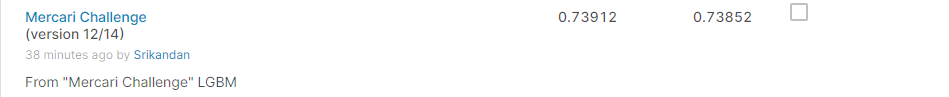

In [78]:
Image(filename='Results_lgbm.PNG')

#### 2. Random Forest Regression Model with OneHotEcoder + TFIDF.

In [59]:
# rf_regression = RandomForestRegressor(n_estimators=200, max_features='sqrt', max_depth=50, min_samples_split=8, n_jobs=-1)
# rf_regression.fit(X=train_tf_onehot_data, y=y_train.values)

RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_split=8,
                      n_estimators=200, n_jobs=-1)

In [53]:
rf_regression = RandomForestRegressor(n_estimators=500, max_features='sqrt', max_depth=50, min_samples_split=8, n_jobs=-1)
rf_regression.fit(X=train_tf_onehot_data, y=y_train.values)

RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_split=8,
                      n_estimators=500, n_jobs=-1)

In [54]:
predicted = rf_regression.predict(test_tf_onehot_data)

In [55]:
temp = []
for i in predicted.tolist():
    if i<0:
        temp.append(0.0)
    else:
        temp.append(i) 
        
predicted = temp

In [60]:
output = pd.DataFrame()
output['test_id'] = test_df.reset_index()['test_id']
output['price'] = predicted

In [61]:
output.head()

,test_id,price
0,0,20.646734
1,1,19.935548
2,2,34.433084
3,3,22.136485
4,4,20.587994


In [62]:
output.to_csv('submission_rf.csv', index=False)

In [63]:
submission = pd.read_csv('submission_rf.csv', sep='\t')
submission.head()

,"test_id,price"
0,"0,20.646734434846064"
1,"1,19.935547530036953"
2,"2,34.43308427500541"
3,"3,22.136484805518545"
4,"4,20.587994163199618"


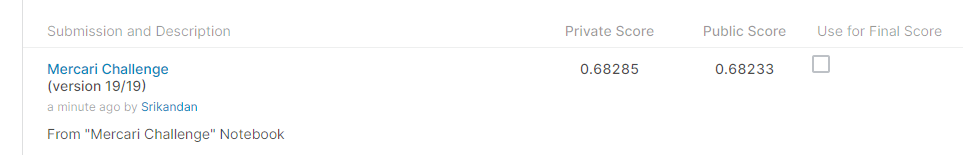

In [64]:
Image(filename='Results_RF.PNG')

#### 3. Linear Regression Model with OneHotEcoder + TFIDF.

In [66]:
linear_regression = SGDRegressor(alpha=0.001, learning_rate='adaptive', max_iter=500)
linear_regression.fit(X=train_tf_onehot_data, y=y_train.values)

SGDRegressor(alpha=0.001, learning_rate='adaptive', max_iter=500)

In [67]:
predicted = linear_regression.predict(test_tf_onehot_data)

In [68]:
temp = []
for i in predicted.tolist():
    if i<0:
        temp.append(0.0)
    else:
        temp.append(i) 
        
predicted = temp

In [69]:
output = pd.DataFrame()
output['test_id'] = test_df.reset_index()['test_id']
output['price'] = predicted

In [70]:
output.head()

,test_id,price
0,0,8.941296
1,1,0.000000
2,2,48.964087
3,3,14.266043
4,4,11.566573


In [71]:
output.to_csv('submission_linear.csv', index=False)

In [72]:
submission = pd.read_csv('submission_linear.csv', sep='\t')
submission.head()

,"test_id,price"
0,"0,8.941295847949306"
1,"1,0.0"
2,"2,48.96408699228117"
3,"3,14.266043340266371"
4,"4,11.566572875805289"


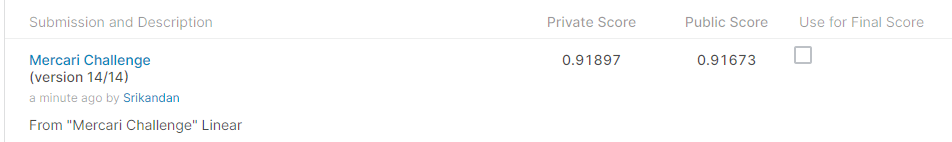

In [76]:
Image(filename='Results_Linear.PNG')